<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E3%83%92%E3%83%88%E3%81%AE%E4%BA%88%E6%B8%AC%E3%81%A8%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google colabをマウント

In [3]:
'''
ファイル構成
My Drive---Deep learning---applstra------train----appl
                              |      |         |--stra
                              |      |    
                              |      |---val-------appl
                              |                 |--stra
                              |---applstra.pth
'''

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#モデルのロード

In [12]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
#モデルのサマリー（省略可）
from torchsummary import summary
summary(model_ft, (3, 224, 224))

#画像とラベル表示のための関数を定義

In [0]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(Variable(image_tensor))
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #正解は青色、不正解は赤色で表示する
    _, pred = torch.max(output, 1)
    predicted_label = class_name[pred]

    return(predicted_label)  #class_nameの番号で出力される

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)

def hum_pred():
    while True:
        pred = input('ラベルを入力して下さい   '+ class_name[0]+'：「0」、'+class_name[1]+'：「1」')
        if pred == '0':
            break
        elif pred == '1':
            break
        else:
            print('0か1を入力して下さい')
    hum_label = class_name[int(pred)]
    return hum_label

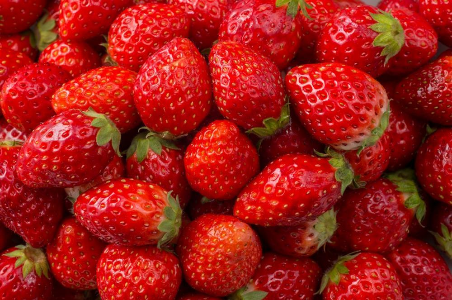

ラベルを入力して下さい   appl：「0」、stra：「1」4
0か1を入力して下さい
ラベルを入力して下さい   appl：「0」、stra：「1」1


In [42]:
showImage(image_path[1])

while True:
    pred = input('ラベルを入力して下さい   '+ class_name[0]+'：「0」、'+class_name[1]+'：「1」')
    if pred == '0':
            break
    elif pred == '1':
            break
    else:
            print('0か1を入力して下さい')
hum_label = class_name[int(pred)]
print(hum_label)

#メインプログラム



In [7]:
#ファイル名の取得
image_path = glob.glob("/content/drive/My Drive/Deep_learning/applstra/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print(len(image_path))
print(image_path) 

#対象画像のパスからラベルを抜き出す


#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)

127
['/content/drive/My Drive/Deep_learning/applstra/val/stra/slproImg_201804251819070.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/tbm_20191101184911.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/top_img_ichigo2019.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/rgn1910240057-p1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/ti1-1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/top_on_img.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/PED_kajiraretaapple2_TP_V4.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/sd1_1567a4d71d4bf1ae380d801354c792930e316b05.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ph1_komitsu.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/tochigi-ichigo_no_sato001.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/photo01.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/top-image.jpg', '/content/driv

・True positive (TN) <br>
・False positive (FP) <br>
・True negative (TN) <br>
・False negative (FN) <br>

1. Accuracy = (TP + TN)/ (TP + TN + FP + FN)
2. Precision = TP/(FP + TP) ※positive predictive value
3. Recall = TP/(TP + FN)　※sensitivity
4. Specificity = TN/(FP + TN)
5. F_value = (2RecallPrecision)/(Recall+Precision)

In [0]:
TP = 0 #True positive
FP = 0 #False positive
TN = 0 #True negative
FN = 0 #False negative


for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_tensor = image_transform(i)  #予測のための画像下処理
    predicted_label = image_eval(image_tensor, label)  #予測結果を出力   
    human_pred = 
    
    print('Image: '+ image_name)
    print('Label: '+ label)
    print('Pred: '+ predicted_label)
    showImage(i)  #画像を表示
    print() #空白行を入れる
    time.sleep(0.1)

    if label == class_name[0]:
        if predicted_label == class_name[0]:
            TP += 1
        else:
            FN += 1
    elif label == class_name[1]:
        if predicted_label == class_name[1]:
            TN += 1
        else:
            FP += 1

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))




    

#不正解例のみを表示する

In [0]:
for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_tensor = image_transform(i)  #予測のための画像下処理
    predicted_label = image_eval(image_tensor, label)  #予測結果を出力   
    
    if label != predicted_label:
        print('Image: '+ image_name)
        print('Label: '+ label)
        print('Pred: '+ predicted_label)
        showImage(i)  #画像を表示
        print() #空白行を入れる
        time.sleep(0.1)
    else:
        pass